# Time Series Mini-Poject

### This project will explore and forcast the average temperature for Los Angeles, CA

In [1]:
import pandas as pd
import numpy as np

from datetime import timedelta, datetime

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env as ev

import warnings
warnings.filterwarnings("ignore")

#### Project Goals: 
The goal of this mini-project is to practice what I have learned at each stage of the pipeline throughout the time series module. Use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. Select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. Then model those patterns to forecast temperature into the future.

- Link to the Data: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [2]:
# Importing the csv that contains temperature data for major cities
city_wx = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')

In [3]:
city_wx.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [4]:
# Creating a new dataframe for Los Angeles weather
la_wx = city_wx[city_wx.City =='Los Angeles']

In [5]:
la_wx.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
131846,1849-01-01,8.819,2.558,Los Angeles,United States,34.56N,118.70W
131847,1849-02-01,9.577,1.970,Los Angeles,United States,34.56N,118.70W
131848,1849-03-01,11.814,2.173,Los Angeles,United States,34.56N,118.70W
131849,1849-04-01,13.704,2.902,Los Angeles,United States,34.56N,118.70W
131850,1849-05-01,14.834,2.017,Los Angeles,United States,34.56N,118.70W


In [6]:
# Converting average temperature from Celsius to Fahrenheit
la_wx['avg_temp_f'] = la_wx.AverageTemperature * 1.8 + 32

In [7]:
la_wx.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_f
131846,1849-01-01,8.819,2.558,Los Angeles,United States,34.56N,118.70W,47.8742
131847,1849-02-01,9.577,1.970,Los Angeles,United States,34.56N,118.70W,49.2386
131848,1849-03-01,11.814,2.173,Los Angeles,United States,34.56N,118.70W,53.2652
131849,1849-04-01,13.704,2.902,Los Angeles,United States,34.56N,118.70W,56.6672
131850,1849-05-01,14.834,2.017,Los Angeles,United States,34.56N,118.70W,58.7012


In [8]:
la_wx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1977 entries, 131846 to 133822
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             1977 non-null   object 
 1   AverageTemperature             1977 non-null   float64
 2   AverageTemperatureUncertainty  1977 non-null   float64
 3   City                           1977 non-null   object 
 4   Country                        1977 non-null   object 
 5   Latitude                       1977 non-null   object 
 6   Longitude                      1977 non-null   object 
 7   avg_temp_f                     1977 non-null   float64
dtypes: float64(3), object(5)
memory usage: 139.0+ KB


In [9]:
la_wx.dt = pd.to_datetime(la_wx.dt)

In [10]:
la_wx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1977 entries, 131846 to 133822
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   dt                             1977 non-null   datetime64[ns]
 1   AverageTemperature             1977 non-null   float64       
 2   AverageTemperatureUncertainty  1977 non-null   float64       
 3   City                           1977 non-null   object        
 4   Country                        1977 non-null   object        
 5   Latitude                       1977 non-null   object        
 6   Longitude                      1977 non-null   object        
 7   avg_temp_f                     1977 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 139.0+ KB


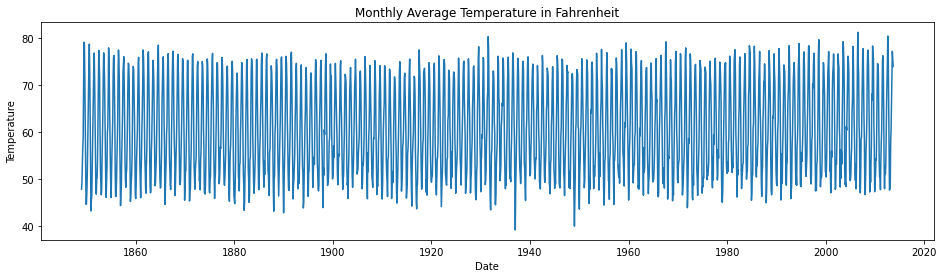

In [11]:
# Plot of the tempuratures
plt.figure(figsize=(16, 4))
sns.lineplot(x="dt", y="avg_temp_f", data=la_wx)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Monthly Average Temperature in Fahrenheit')
plt.show()

### Data Split

In [12]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(la_wx) * .5)

# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(la_wx) * .3)

# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(la_wx) - train_size - validate_size)

# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size

# split into train, validation, test
train = la_wx[: train_size]
validate = la_wx[train_size : validate_end_index]
test = la_wx[validate_end_index :]

In [13]:
# sum of train, validate and test = total number of rows? 
len(train) + len(validate) + len(test) == len(la_wx)

True

In [14]:
# test the row starts
pd.concat([train.head(1), la_wx.head(1)])

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_f
131846,1849-01-01,8.819,2.558,Los Angeles,United States,34.56N,118.70W,47.8742
131846,1849-01-01,8.819,2.558,Los Angeles,United States,34.56N,118.70W,47.8742


In [15]:
# test the split between validate and test
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_f
133426,1980-09-01,21.074,0.321,Los Angeles,United States,34.56N,118.70W,69.9332
133427,1980-10-01,18.243,0.730,Los Angeles,United States,34.56N,118.70W,64.8374


In [16]:
# compare the last row of test to last row of df
pd.concat([test.tail(1), la_wx.tail(1)])

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_f
133822,2013-09-01,23.301,0.984,Los Angeles,United States,34.56N,118.70W,73.9418
133822,2013-09-01,23.301,0.984,Los Angeles,United States,34.56N,118.70W,73.9418


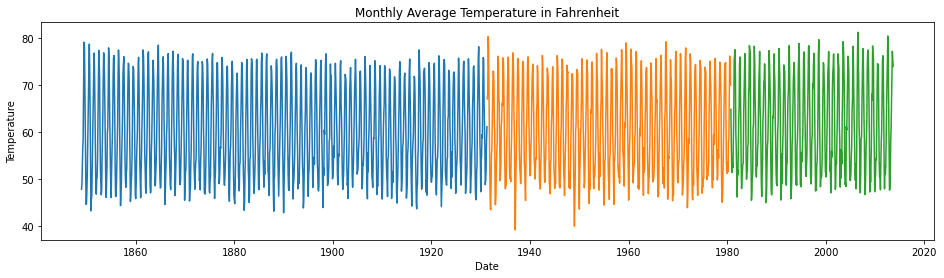

In [17]:
# plot the data points, color by train, validate, test
plt.figure(figsize=(16, 4))
sns.lineplot(x="dt", y="avg_temp_f", data=train)
sns.lineplot(x="dt", y="avg_temp_f", data=validate)
sns.lineplot(x="dt", y="avg_temp_f", data=test)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Monthly Average Temperature in Fahrenheit')
plt.show()

In [18]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df =pd.DataFrame(columns = ['model_type', 'target_variable', 'rmse'])

In [19]:
eval_df

,model_type,target_variable,rmse


In [20]:
# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    the evaluate function will take in the actual values in validate and the predicted values
    and compute the mean_squared_error and then take the square root and round to 0 decimals. 
    It will return the rmse, an integer. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [21]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    takes a model type as a str. The Target variable as a str.
    Runs the evaluate() function to compute rmse.
    Appends the information. Returns new dataframe
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type],
        'target_variable': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

### Forecast

##### Simple Average

In [22]:
temps = round(train['avg_temp_f'].mean(), 2)


def make_predictions(temps):
    yhat_df = pd.DataFrame({'avg_temp_f': [temps]}, index = validate.dt)
    return yhat_df

In [23]:
yhat_df = make_predictions(temps)
yhat_df.head(2)

,avg_temp_f
dt,
1931-05-01,60.15
1931-06-01,60.15


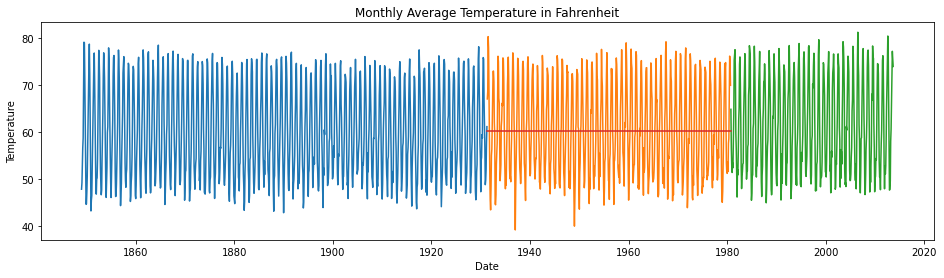

In [24]:
# plot the data points, color by train, validate, test
plt.figure(figsize=(16, 4))
sns.lineplot(x="dt", y="avg_temp_f", data=train)
sns.lineplot(x="dt", y="avg_temp_f", data=validate)
sns.lineplot(x="dt", y="avg_temp_f", data=test)
sns.lineplot(x="dt", y="avg_temp_f", data=yhat_df)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Monthly Average Temperature in Fahrenheit')

plt.show()

In [25]:
eval_df = append_eval_df(model_type = 'simple_average', target_var = 'avg_temp_f')

In [26]:
eval_df

,model_type,target_variable,rmse
0,simple_average,avg_temp_f,10.0


### Predict Based on Previous Cycle
Weather is cyclical annually; therefore, I will use the previous cycle method next.

In [34]:
la_wx[la_wx.dt.dt.year == 2013]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_f
133814,2013-01-01,8.813,0.651,Los Angeles,United States,34.56N,118.70W,47.8634
133815,2013-02-01,9.804,0.319,Los Angeles,United States,34.56N,118.70W,49.6472
133816,2013-03-01,14.463,0.727,Los Angeles,United States,34.56N,118.70W,58.0334
133817,2013-04-01,15.921,0.539,Los Angeles,United States,34.56N,118.70W,60.6578
133818,2013-05-01,19.028,0.531,Los Angeles,United States,34.56N,118.70W,66.2504
133819,2013-06-01,22.434,0.416,Los Angeles,United States,34.56N,118.70W,72.3812
133820,2013-07-01,25.090,0.334,Los Angeles,United States,34.56N,118.70W,77.1620
133821,2013-08-01,24.232,0.384,Los Angeles,United States,34.56N,118.70W,75.6176
133822,2013-09-01,23.301,0.984,Los Angeles,United States,34.56N,118.70W,73.9418


In [42]:
# Resplit
    # Train: first date through 1972
train = la_wx.loc[:133333]
    # Validate is 1973 through 1992 (20 yrs)
validate = la_wx.loc[133334: 133573]
    # Test is 1993 through 2013 (20 yrs)
test = la_wx.loc[133574:]

In [43]:
train

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_f
131846,1849-01-01,8.819,2.558,Los Angeles,United States,34.56N,118.70W,47.8742
131847,1849-02-01,9.577,1.970,Los Angeles,United States,34.56N,118.70W,49.2386
131848,1849-03-01,11.814,2.173,Los Angeles,United States,34.56N,118.70W,53.2652
131849,1849-04-01,13.704,2.902,Los Angeles,United States,34.56N,118.70W,56.6672
131850,1849-05-01,14.834,2.017,Los Angeles,United States,34.56N,118.70W,58.7012
...,...,...,...,...,...,...,...,...
133329,1972-08-01,23.965,0.553,Los Angeles,United States,34.56N,118.70W,75.1370
133330,1972-09-01,20.678,0.465,Los Angeles,United States,34.56N,118.70W,69.2204
133331,1972-10-01,15.809,0.656,Los Angeles,United States,34.56N,118.70W,60.4562
133332,1972-11-01,11.280,0.378,Los Angeles,United States,34.56N,118.70W,52.3040


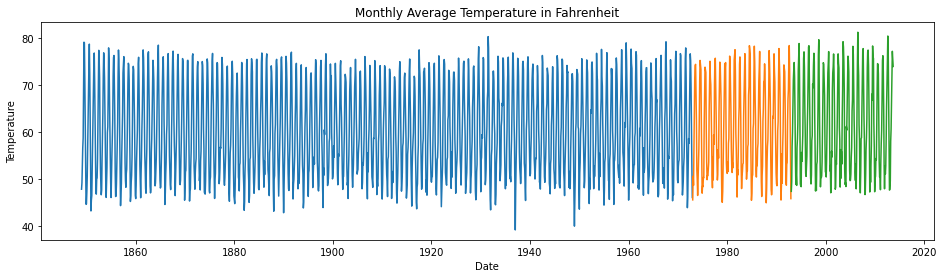

In [44]:
# plot the data points, color by train, validate, test
plt.figure(figsize=(16, 4))
sns.lineplot(x="dt", y="avg_temp_f", data=train)
sns.lineplot(x="dt", y="avg_temp_f", data=validate)
sns.lineplot(x="dt", y="avg_temp_f", data=test)

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Monthly Average Temperature in Fahrenheit')
plt.show()